<a href="https://colab.research.google.com/github/vlozg/speech_hmm/blob/main/Test_DiagHMM_002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LƯU Ý: NOTEBOOK NÀY CHỈ DÙNG ĐỂ SHOW KẾT QUẢ CHẠY, KHÔNG NÊN CHẠY LẠI NOTEBOOK NÀY 
(VÌ TRONG NÀY CÓ CODE LƯU LẠI PRETRAINED MODEL LÊN DRIVE SẼ BỊ XÓA)

# Speech to text with HMM

- **Bài toán**: Chuyển giọng nói thành văn bản
    - **Input**: Đoạn ghi âm chứa nội dung là các số từ 0 đến 9
    - **Output**: Phân lớp của đoạn ghi âm

# Các biến thiết lập cho thử nghiệm

In [ ]:
n_mfcc_ceptrum = 12
n_delta_features = 1
fsdd_split = 0.4
wolfram_split = 0
experiment_id = '002'

In [ ]:
n_mfcc_features = n_mfcc_ceptrum * (1+n_delta_features)
n_mfcc_features

24

# Import và cài đặt thư viện

In [ ]:
# cài lib. note: cài xong phải restart runtime
!pip install pydub
!pip install pomegranate
!pip install python_speech_features

In [ ]:
# Xác thực google để upload/download qua google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Quản lý file, folder
import os
from shutil import copyfile, rmtree
import random

# Xử lý audio
import librosa
import librosa.display
from python_speech_features import mfcc
from scipy.io import wavfile

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pomegranate # Thư viện cho mô hình xác suất
from pomegranate import *

# Tải dữ liệu và lấy xác thực Google

Dữ liệu dùng để huấn luyện và đánh giá, còn xác thực google thì dùng để upload/download mô hình trên drive.

In [ ]:
%%capture
# download wolfram
if not os.path.isfile('./dataset_1_wolfram.zip'):
  !gdown --id 115tIAitBNeJC0DwrP-ZyJ6RS3TyWN0qD
  !unzip -o dataset_1_wolfram.zip

# dowload FSDD
if not os.path.isfile('./dataset_2_FSDD.zip'):
  !gdown --id 1Ua9zlPBc0Fv4xGHSQTb7eIvUh_dqFI6P
  !unzip -o dataset_2_FSDD.zip

# download self recorded audio
!gdown --id 1lH_k1AYMVlJvodtZdD7OK2zkdPXxlW9i

In [ ]:
# Lấy xác thực google để upload/download file
auth.authenticate_user()
gauth =  GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Hàm xử lý âm thanh

In [ ]:
def scaleAddNoise(wave):
  return ((wave - wave.mean()) / wave.std()) + 0.2*np.random.normal(size=wave.shape)

def read_process_audio(full_audio_path):
  # Bắt buộc âm thanh đọc vào phải cùng sample rate
  sample_rate, wave =  wavfile.read(full_audio_path)
  if sample_rate != 16000:
    wave, sample_rate =  librosa.load(full_audio_path, sr=16000) # Hàm đọc của librosa quá chậm, scipy nhanh gấp 5-10 lần
  else:
    wave=wave/32768 # Chuẩn hóa về số thực
  wave = np.pad(wave, (2000,2000), 'constant', constant_values=(0.0,0.0))
  wave = scaleAddNoise(wave)
  return wave, sample_rate

def extract_mfcc(wave, sample_rate):
  mfccs = librosa.feature.mfcc(y=wave, sr=sample_rate, n_mfcc=n_mfcc_ceptrum+2, n_mels=40, lifter=40)[2:,:].T/800
  return mfccs

def mfcc_delta_features(mfcc, order):
  if order==0:
    return mfcc
  dmfcc = librosa.feature.delta(mfcc, order=order)
  return dmfcc

def full_mfcc_from_file(full_audio_path):
  wave, sr = read_process_audio(full_audio_path)
  mfccs = extract_mfcc(wave, sr)
  full_mfccs = mfccs
  if n_delta_features >= 1:
    mfccs_d1 = mfcc_delta_features(mfccs, 1)
    full_mfccs = np.hstack([full_mfccs,mfccs_d1])
  if n_delta_features >= 2:
    mfccs_d2 = mfcc_delta_features(mfccs, 2)
    full_mfccs = np.hstack([full_mfccs,mfccs_d2])
  return full_mfccs

# Hàm bổ trợ

In [ ]:
def buildDataSet(dir):
    # Filter out the wav audio files under the dir
    fileList = [f for f in os.listdir(dir) if os.path.splitext(f)[1] == '.wav']
    dataset = {}
    for fileName in fileList:
        tmp = fileName.split('.')[0]
        label = tmp.split('_')[1]

        # label = filename.split('_')[0]
        feature = full_mfcc_from_file(dir+fileName)
        if label not in dataset.keys():
            dataset[label] = []
            dataset[label].append(feature)
        else:
            exist_feature = dataset[label]
            exist_feature.append(feature)
            dataset[label] = exist_feature
    return dataset

def makeTrainTestDir(mainFolder, filenames, rate):
    paths = [f'{mainFolder}',
             f'{mainFolder}/train_audio',
             f'{mainFolder}/test_audio']

    for path in paths:
        try:
            os.mkdir(path)
        except:
            rmtree(path)
            os.mkdir(path)

    random.seed(1)
    random.shuffle(filenames)
    splitPoint = int(len(filenames)*rate)
    trainFilenames = filenames[:splitPoint]
    testFilenames = filenames[splitPoint:]

    for filename in trainFilenames:
        copyfile(filename[0], f"{paths[1]}/{filename[1]}")

    for filename in testFilenames:
        copyfile(filename[0], f"{paths[2]}/{filename[1]}")

# Setup thư mục chứa data

In [ ]:
def formatFilenameFSDD(dir):
    filenames = []
    count = 0
    for filename in os.listdir(dir):
        tmp = str(count) + '_' + filename.split('_')[0] + '.wav'
        filenames.append((f"{dir}/{filename}", tmp))
        count += 1
    return filenames

filenames = formatFilenameFSDD('./dataset_2_FSDD')
makeTrainTestDir('fsdd', filenames, fsdd_split)

In [ ]:
def formatFilenameWolfram(dir):
    filenames = []
    count = 0
    folders = os.listdir(dir)
    for folder in folders:
        for filename in os.listdir(f'{dir}/{folder}'):
            tmp = str(count) + '_' + folder.split('_')[0] + '.wav'
            filenames.append((f"{dir}/{folder}/{filename}", tmp))
            count += 1

    return filenames

filenames = formatFilenameWolfram('./dataset_1_wolfram')
makeTrainTestDir('wolfram', filenames, wolfram_split)

# Khám phá dữ liệu âm thanh

In [ ]:
sample_fsdd_file = 'fsdd/test_audio/1000_1.wav'
sample_spcm_file = 'wolfram/test_audio/0_1.wav'
sample_self_file = 'myaudio.wav'

In [ ]:
wave1, sample_rate1 = read_process_audio(sample_fsdd_file)
wave2, sample_rate2 = read_process_audio(sample_spcm_file)
wave3, sample_rate3 = read_process_audio(sample_self_file)

## So sánh waveform

In [ ]:
def plot_waveform(sample_rate, wave, ax):
  length = wave.shape[0] / sample_rate
  time = np.linspace(0., length, wave.shape[0])
  ax.plot(time, wave)

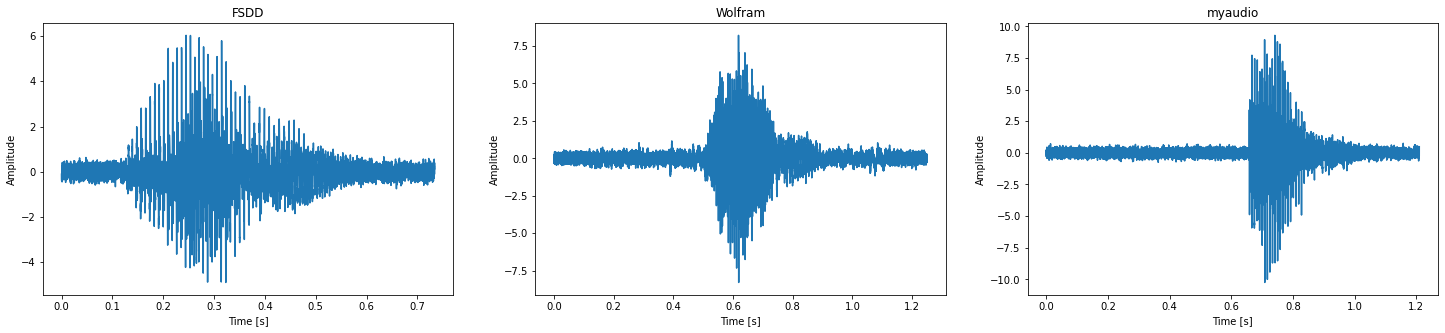

In [ ]:
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(25, 5)
axs[0].set(title='FSDD', xlabel="Time [s]", ylabel="Amplitude")
axs[1].set(title='Wolfram', xlabel="Time [s]", ylabel="Amplitude")
axs[2].set(title='myaudio', xlabel="Time [s]", ylabel="Amplitude")
plot_waveform(sample_rate1, wave1, axs[0])
plot_waveform(sample_rate2, wave2, axs[1])
plot_waveform(sample_rate3, wave3, axs[2])

## So sánh spectrogram

In [ ]:
def plot_melspec(sr, y, ax):
  S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40, fmax=8000)
  S_dB = librosa.power_to_db(S, ref=np.max)
  img = librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=sr,
                          ax=ax)
  return img

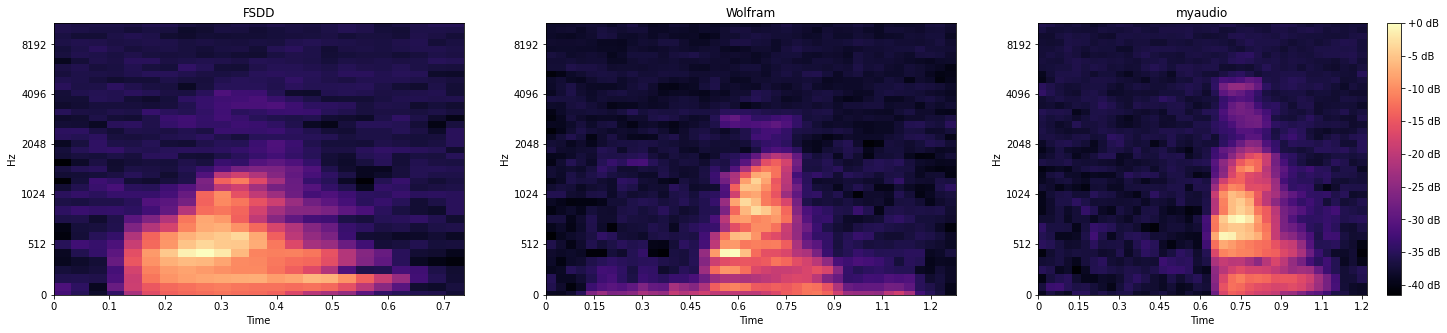

In [ ]:
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(25, 5)
axs[0].set(title='FSDD', xlabel="Time [s]", ylabel="Amplitude")
axs[1].set(title='Wolfram', xlabel="Time [s]", ylabel="Amplitude")
axs[2].set(title='myaudio', xlabel="Time [s]", ylabel="Amplitude")
img = plot_melspec(sample_rate1, wave1, axs[0])
fig.colorbar(img, format='%+2.0f dB')
plot_melspec(sample_rate2, wave2, axs[1])
plot_melspec(sample_rate3, wave3, axs[2])
fig.show()

Ghi chú: dễ dàng nhìn thấy điểm giống nhau ở vùng sáng có hình viên socola Hershey's Kisses

![](http://cdn.shopify.com/s/files/1/0972/7116/products/Hershey_s_Milk_Chocolate_Kisses_600x.jpg?v=1576258899)

## So sánh MFCC

In [ ]:
def plot_mfcc(sr, y, ax):
  mfccs = extract_mfcc(y, sr).T
  rdgn = sns.diverging_palette(h_neg=235, h_pos=4, s=80, l=46, sep=3, as_cmap=True)
  sns.heatmap(mfccs, cmap=rdgn, center=0.00, cbar=True, ax=ax, vmax=1/6, vmin=-1/6)
  ax.invert_yaxis()

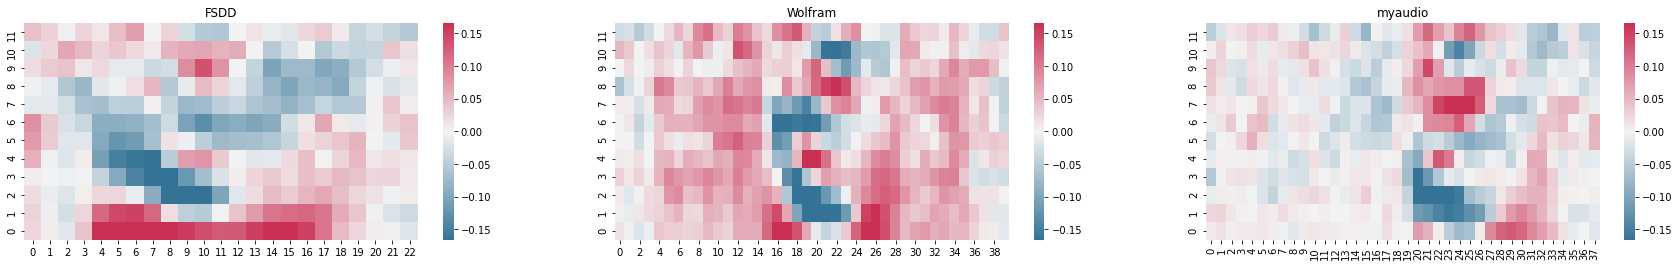

In [ ]:
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(30, 4)
axs[0].set(title='FSDD')
plot_mfcc(sample_rate1, wave1, axs[0])
axs[1].set(title='Wolfram')
plot_mfcc(sample_rate2, wave2, axs[1])
axs[2].set(title='myaudio')
plot_mfcc(sample_rate3, wave3, axs[2])
fig.show()

# Huấn luyện mô hình (có thể bỏ qua vì mô hình đã save trên drive)

## Hàm train mô hình

In [ ]:
def Generate_DiagGMM(full_fset, n_features, n_states=5, n_cmps=3):
  means = np.mean(full_fset, axis=0)
  stds = np.std(full_fset, axis=0)
  # initial values for all gaussian components
  np.random.seed(None)
  dist_init = np.random.random((n_states, n_cmps, n_features, 2))
  dist_init[..., 0] -= 0.5  # center means to 0.0
  #for feat_i in range(n_features):
      # random init mean in range [-std, std)
      #dist_init[..., feat_i, 0] *= 2 * stds[feat_i]
      #dist_init[..., feat_i, 0] += means[feat_i]
      # random init std in range 1std/n_components
      #dist_init[..., feat_i, 1] *= stds[feat_i] / n_cmps

  dists = tuple(
      GeneralMixtureModel(list(
          IndependentComponentsDistribution(tuple(
              NormalDistribution(*dist_init[state_i, cmp_i, feat_i, :])
              for feat_i in range(n_features)
          ))
          for cmp_i in range(n_cmps)
      ))
      if n_cmps > 1 else
      IndependentComponentsDistribution(tuple(
          NormalDistribution(*dist_init[state_i, 0, feat_i, :])
          for feat_i in range(n_features)
      ))
      for state_i in range(n_states)
  )
  return dists

In [ ]:
# Generate progressive HMM model
def left_right_GMMHMM(seed_sample, x_dim, n_states=10, n_modals=9, random=0):
  rng = np.random.RandomState(random)
  if random!=0:
    init_prob = lambda: rng.rand(1)[0]
    
  model = HiddenMarkovModel()
  states = [State( state_model, name=f"H{i}" ) for i, state_model in enumerate(Generate_DiagGMM(seed_sample, x_dim, n_states, n_modals))]
  model.add_states(states)
  model.add_transition(model.start, states[0], 1)
  for i in range(n_states-1):
    model.add_transition(states[i], states[i], 0.5)
    model.add_transition(states[i], states[i+1], 0.5)
  model.add_transition(states[n_states-1], states[n_states-1], 0.5)
  model.add_transition(states[n_states-1], model.end, 0.5)
  model.bake()
  return model

In [ ]:
def train_GMMHMM(dataset, input_dim, n_hidden_state, n_gauss_modal):
    GMMHMM_Models = dict()

    for label in dataset.keys():
        print(f"Training model detect {label}")
        model = left_right_GMMHMM(dataset[label][0], input_dim, n_hidden_state, n_gauss_modal)
        model.fit(dataset[label], verbose=True, multiple_check_input=False)  # get optimal parameters
        GMMHMM_Models[label] = model

    return GMMHMM_Models

## Hàm test mô hình

In [ ]:
# test model
def evaluateModel(testDataSet, model):
    score_cnt = 0
    total = 0
    for label in testDataSet.keys():
        features = testDataSet[label]
        total += len(features)
        for sample in features:
            scoreList = {}
            for model_label in model.keys():
                score = model[model_label].log_probability(sample)
                scoreList[model_label] = score
            predict = max(scoreList, key=scoreList.get)
            if predict == label:
                score_cnt += 1
        print(f"{label}: ({score_cnt}/{total})")

    print("Final recognition rate is %.2f"%(100.0*score_cnt/total), "%")

## Đọc và tiền xử lý data

In [ ]:
# prepare data for training
master_path = 'fsdd'

trainDir = master_path + '/train_audio/'
trainDataSet = buildDataSet(trainDir)
print("Finish prepare the training data")

# prepare data for testing
testDir = master_path + '/test_audio/'
testDataSet = buildDataSet(testDir)
print("Finish prepare the test data")

Finish prepare the training data
Finish prepare the test data


## **Mô hình 1**
- 10 hiddent states
- Multivariate Diagonal Gauss cho emission probs

In [ ]:
%%time
# train
hmmModels = train_GMMHMM(trainDataSet, n_mfcc_features,10,1)
print("Finish training of the GMM_HMM models for digits 0-9")

Training model detect 1
[1] Improvement: 1048201.9340137856	Time (s): 0.04251
[2] Improvement: 6254.61095069017	Time (s): 0.0342
[3] Improvement: 1635.4806527971814	Time (s): 0.03629
[4] Improvement: 99.71470432382193	Time (s): 0.0383
[5] Improvement: 32.77180384306121	Time (s): 0.03482
[6] Improvement: 9.733608342037769	Time (s): 0.03481
[7] Improvement: 1.430339333921438	Time (s): 0.03508
[8] Improvement: 0.3021970115369186	Time (s): 0.03482
[9] Improvement: 0.13687163061695173	Time (s): 0.04082
[10] Improvement: 297.95155839133076	Time (s): 0.03865
[11] Improvement: 1141.9066721349373	Time (s): 0.04215
[12] Improvement: 548.1397526433284	Time (s): 0.03532
[13] Improvement: 604.3842564676015	Time (s): 0.03511
[14] Improvement: 614.7954818223661	Time (s): 0.03538
[15] Improvement: 466.3208057300362	Time (s): 0.03783
[16] Improvement: 1061.1335272962751	Time (s): 0.03747
[17] Improvement: 801.0222018088098	Time (s): 0.03506
[18] Improvement: 247.4747323624033	Time (s): 0.03526
[19] Imp

In [ ]:
evaluateModel(trainDataSet, hmmModels)
evaluateModel(testDataSet, hmmModels)

1: (101/117)
2: (212/233)
7: (304/327)
6: (392/470)
8: (515/599)
0: (634/721)
9: (736/840)
5: (863/970)
3: (931/1074)
4: (1050/1200)
Final recognition rate is 87.50 %
0: (166/178)
3: (273/374)
9: (416/555)
7: (610/761)
4: (771/935)
5: (940/1105)
8: (1101/1276)
1: (1265/1459)
2: (1433/1643)
6: (1532/1800)
Final recognition rate is 85.11 %


In [ ]:
# lưu lại model
for model_label in hmmModels.keys():
  file = drive.CreateFile({'title': f'hmm[{model_label}]_{n_mfcc_features}_10_1[{experiment_id}].json', 'parents': [{'id': '1QPUr4vwYHu3n9iH3iQmnvDUt2Dgx4V3Y'}]})
  file.SetContentString(hmmModels[model_label].to_json())
  file.Upload()

## **Mô hình 2**
- 5 hiddent states
- Multivariate Diagonal Gauss cho emission probs

In [ ]:
%%time
# train
hmmModels = train_GMMHMM(trainDataSet, n_mfcc_features,5,1)
print("Finish training of the GMM_HMM models for digits 0-9")

Training model detect 1
[1] Improvement: 2277685.35124659	Time (s): 0.01916
[2] Improvement: 668.6763357237505	Time (s): 0.01951
[3] Improvement: 364.55620771987014	Time (s): 0.01966
[4] Improvement: 756.9769552892831	Time (s): 0.01956
[5] Improvement: 1125.889088788157	Time (s): 0.0195
[6] Improvement: 697.7573098120047	Time (s): 0.01928
[7] Improvement: 566.20966508938	Time (s): 0.01933
[8] Improvement: 293.94593774940586	Time (s): 0.01985
[9] Improvement: 206.88525969762122	Time (s): 0.02262
[10] Improvement: 195.1472508003353	Time (s): 0.01989
[11] Improvement: 133.5279552807333	Time (s): 0.02022
[12] Improvement: 189.95867710304447	Time (s): 0.02072
[13] Improvement: 157.19025603064802	Time (s): 0.02055
[14] Improvement: 90.02433254013886	Time (s): 0.02017
[15] Improvement: 65.94906780897873	Time (s): 0.01999
[16] Improvement: 50.83183904516045	Time (s): 0.0201
[17] Improvement: 100.25951887082192	Time (s): 0.02366
[18] Improvement: 149.63048637006432	Time (s): 0.01919
[19] Improv

In [ ]:
evaluateModel(trainDataSet, hmmModels)
evaluateModel(testDataSet, hmmModels)

1: (14/117)
2: (109/233)
7: (201/327)
6: (276/470)
8: (277/599)
0: (314/721)
9: (427/840)
5: (487/970)
3: (550/1074)
4: (672/1200)
Final recognition rate is 56.00 %
0: (48/178)
3: (138/374)
9: (307/555)
7: (489/761)
4: (651/935)
5: (736/1105)
8: (737/1276)
1: (772/1459)
2: (920/1643)
6: (1013/1800)
Final recognition rate is 56.28 %


In [ ]:
# lưu lại model
for model_label in hmmModels.keys():
  file = drive.CreateFile({'title': f'hmm[{model_label}]_{n_mfcc_features}_5_1[{experiment_id}].json', 'parents': [{'id': '1QPUr4vwYHu3n9iH3iQmnvDUt2Dgx4V3Y'}]})
  file.SetContentString(hmmModels[model_label].to_json())
  file.Upload()

## **Mô hình 3**
- 3 hiddent states
- Multivariate Diagonal Gauss cho emission probs

In [ ]:
%%time
# train
hmmModels = train_GMMHMM(trainDataSet, n_mfcc_features,3,1)
print("Finish training of the GMM_HMM models for digits 0-9")

Training model detect 1
[1] Improvement: 273771.0254691655	Time (s): 0.01365
[2] Improvement: 3596.974655538099	Time (s): 0.01466
[3] Improvement: 203.72735330538126	Time (s): 0.01449
[4] Improvement: 6.809242741117487	Time (s): 0.01443
[5] Improvement: 0.507326329825446	Time (s): 0.01426
[6] Improvement: 0.01890150282997638	Time (s): 0.01429
[7] Improvement: 0.0006116874283179641	Time (s): 0.01429
[8] Improvement: 2.0029052393510938e-05	Time (s): 0.01417
[9] Improvement: 6.596674211323261e-07	Time (s): 0.01423
[10] Improvement: 2.1798769012093544e-08	Time (s): 0.01445
[11] Improvement: 7.566995918750763e-10	Time (s): 0.01468
Total Training Improvement: 277579.0635809815
Total Training Time (s): 0.1797
Training model detect 2
[1] Improvement: 249127.28255406674	Time (s): 0.01679
[2] Improvement: 1594.9683278063458	Time (s): 0.01441
[3] Improvement: 222.513822288136	Time (s): 0.01387
[4] Improvement: 315.27271165078855	Time (s): 0.01392
[5] Improvement: 241.4750800504844	Time (s): 0.014

In [ ]:
evaluateModel(trainDataSet, hmmModels)
evaluateModel(testDataSet, hmmModels)

1: (84/117)
2: (186/233)
7: (211/327)
6: (312/470)
8: (315/599)
0: (323/721)
9: (353/840)
5: (396/970)
3: (398/1074)
4: (505/1200)
Final recognition rate is 42.08 %
0: (16/178)
3: (21/374)
9: (54/555)
7: (104/761)
4: (253/935)
5: (304/1105)
8: (306/1276)
1: (452/1459)
2: (613/1643)
6: (715/1800)
Final recognition rate is 39.72 %


In [ ]:
# lưu lại model
for model_label in hmmModels.keys():
  file = drive.CreateFile({'title': f'hmm[{model_label}]_{n_mfcc_features}_3_1[{experiment_id}].json', 'parents': [{'id': '1QPUr4vwYHu3n9iH3iQmnvDUt2Dgx4V3Y'}]})
  file.SetContentString(hmmModels[model_label].to_json())
  file.Upload()

# Đọc vào model đã save

In [ ]:
# download pre-trained models
folder_id  = '1QPUr4vwYHu3n9iH3iQmnvDUt2Dgx4V3Y'
file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
for i, file1 in enumerate(sorted(file_list, key = lambda x: x['title']), start=1):
  if (file1['title'][:3] != "hmm" or f"[{experiment_id}]" not in file1['title']):
    continue
  print('Downloading {} from GDrive ({}/{})'.format(file1['title'], i, len(file_list)))
  file1.GetContentFile(file1['title'])

In [ ]:
# Đọc model và tạo classifier `digit_clf`
# model_id có định dạng 13_<số state>_<số mixture>[số stt]
def load_model_as_clf(model_id):
  hmmModels = []
  for model_label in range(10):
    with open(f'hmm[{model_label}]_{model_id}.json','rt') as f:
      hmmModels.append(HiddenMarkovModel().from_json(f.read()))

  digit_clf = BayesClassifier(hmmModels)
  return digit_clf

# Thử model

### Kiểm thử với tập dữ liệu Wolfram

In [ ]:
%%time
testDataset = buildDataSet('./wolfram/test_audio/')

CPU times: user 2min 43s, sys: 2min 9s, total: 4min 53s
Wall time: 2min 28s


In [ ]:
def final_test(testDataset, digit_clf):
  true_cnt = 0
  total = 0
  for label in testDataset.keys():
      iter_cnt = 0
      features = testDataset[label]
      total += len(features)
      for sample in features:
          pred = digit_clf.predict(np.array([sample]))[0]
          if pred == int(label):
              iter_cnt += 1
      true_cnt += iter_cnt
      print(f"{label}: {iter_cnt}/{len(features)} ({iter_cnt/len(features)})")

  print("Final recognition rate is %.2f"%(100.0*true_cnt/total), "%")

In [ ]:
final_test(testDataset, load_model_as_clf(f"{n_mfcc_features}_10_1[{experiment_id}]"))

4: 1106/2372 (0.4662731871838111)
8: 950/2352 (0.4039115646258503)
7: 910/2377 (0.3828355069415229)
1: 1301/2370 (0.5489451476793249)
2: 1177/2373 (0.49599662873999156)
3: 620/2356 (0.2631578947368421)
6: 542/2369 (0.22878851836217814)
0: 1233/2376 (0.5189393939393939)
5: 1728/2357 (0.7331353415358507)
9: 1789/2364 (0.7567681895093062)
Final recognition rate is 47.98 %


In [ ]:
final_test(testDataset, load_model_as_clf(f"{n_mfcc_features}_5_1[{experiment_id}]"))

4: 1205/2372 (0.5080101180438449)
8: 2/2352 (0.0008503401360544217)
7: 508/2377 (0.21371476651241061)
1: 772/2370 (0.32573839662447257)
2: 551/2373 (0.23219553308048882)
3: 792/2356 (0.3361629881154499)
6: 675/2369 (0.28493035035880115)
0: 61/2376 (0.025673400673400674)
5: 455/2357 (0.19304200254560883)
9: 1825/2364 (0.7719966159052454)
Final recognition rate is 28.93 %


In [ ]:
final_test(testDataset, load_model_as_clf(f"{n_mfcc_features}_3_1[{experiment_id}]"))

4: 894/2372 (0.3768971332209106)
8: 3/2352 (0.0012755102040816326)
7: 99/2377 (0.041649137568363484)
1: 1563/2370 (0.6594936708860759)
2: 974/2373 (0.41045090602612727)
3: 5/2356 (0.0021222410865874364)
6: 387/2369 (0.163360067539046)
0: 16/2376 (0.006734006734006734)
5: 288/2357 (0.12218922358930845)
9: 181/2364 (0.07656514382402707)
Final recognition rate is 18.63 %
